In [1]:
from os import chdir
chdir('/Users/lananhnguyen/Desktop/thesis/thesis_code')
import main.packages.mine_generic as mine_g
import main.packages.mine_specific as mine_s

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna
import json


In [2]:
optuna.logging.set_verbosity(optuna.logging.WARNING)


In [3]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [12]:
def xgb_pred(
    X_train, X_test, y_train, y_test, hyperparam, weight_train=None, weight_test=None
):
    """
    Put it inside the generate_forecast
    """
    # Transform data into xgboost type:
    dtrain = xgb.DMatrix(X_train, label=y_train, weight=weight_train)
    dvalid = xgb.DMatrix(X_test, label=y_test, weight=weight_test)

    # Train model:
    model = xgb.train(
        hyperparam, dtrain, evals=[(dvalid, "validation")], verbose_eval=False
    )

    return model.predict(dvalid)

In [16]:
# Forecast:
def generate_forecast(X, y, N, T, h, hyperparam, weights, verbose=1): # from common function
    """
    Generate recursive forecast
    """
    print(f"Horizon: {h}")
    print("------------------------")
    y_pred_series = []
    for i in range(0, T):  # T+1-h
        X_train = X.iloc[: N+i, :]
        y_train = y.iloc[h: N+i+h, :]
        weight_train = weights[:N+i]

        X_test = X.iloc[N+i : N+i+1, :] 
        y_test = y.iloc[N+i+h : N+i+h+1, :]  
        weight_test = weights[N+i:N+i+1]

        if X_test.index[-1] > X.index[-1]-pd.DateOffset(months=h):
            break

        # Forecast:
        y_pred = xgb_pred(X_train, X_test, y_train, y_test, hyperparam, weight_train, weight_test)

        if verbose == 1:
            print(f"Training period - features: {X_train.index[0]} to {X_train.index[-1]}")
            print(f"Training period - target : {y_train.index[0]} to {y_train.index[-1]}")
            print(f"Test period - features: {X_test.index}")
            print(f"Test period - target : {y_test.index}")
            print(f"Forecast: {y_pred}")
            print("-------------------------------------------------------")

        y_pred_series.append(y_pred[0])
    return y_pred_series

In [5]:
hicp_all_path = 'data/preprocessed/hicp_yoy.csv'
hicp_class_path = 'data/HICP_COICOP10s.xlsx'
model = 'xgb'
date_range = pd.date_range(start=mine_g.train_test_split_date + pd.DateOffset(months=1), end=mine_g.max_X_date, freq='M')


# Food:

In [6]:
category = 'Food'
cat_short = 'food'
hicp_cat_path = f'data/preprocessed/{cat_short}_yoy_infl.csv'
save_cat_file_path = f'data/forecast_results/{cat_short}_forecast.csv'

HICP_monthly, HICP_class, HICP_cat = mine_g.import_data_all(hicp_all_path=hicp_all_path,
                                                     hicp_class_path=hicp_class_path,
                                                     hicp_cat_path=hicp_cat_path)

cat_df = mine_g.split_into_category(category=category,
                             HICP_class=HICP_class,
                             HICP_monthly=HICP_monthly)
food_cat_prediction = pd.DataFrame(index=date_range)

Number of items in Food group:  180


/Users/lananhnguyen/Desktop/thesis/thesis_code/main/packages/mine_generic.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df.fillna(0, inplace=True)


## h = 1

In [22]:
import pandas as pd

def diff_in_months(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

# Current time for reference
current_time = pd.to_datetime('2023-01-31')

weights = [0]*cat_df.shape[0]
# Calculate weights for the training set based on the difference in months
for i in range(cat_df.shape[0]):
    months_diff = diff_in_months(current_time, cat_df.index[i])
    weights[i] = 1 /(months_diff+10)  # Adding 1 to avoid division by zero
weights = [weights[i]/max(weights) for i in range(len(weights))]



In [23]:
h = 1
#cat_df = pd.merge(cat_df, HICP_cat, how='inner', left_index=True, right_index=True)
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

weights_train = weights[:len(X_cat_train)]
weights_test = weights[len(X_cat_train):]


Horizon: 1
Training predictor period: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training dependent variable period: 1997-02-28 00:00:00 to 2015-12-31 00:00:00


In [24]:
def objective_xgb(trial, X_cat_train, y_cat_train, k_fold=5, scaler=True):
    """
    For XBG hyperparam tuning

    """
    params = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "eval_metric": "rmse",
        "tree_method": "hist",
        "n_jobs": -1,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "num_boosted_rounds": 10000,
        "early_stopping_rounds": 50,
        "gamma": trial.suggest_float("gamma", 0.0, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 0.01, 10.0),
        "lambda": trial.suggest_float("lambda", 0.01, 1),
        "alpha": trial.suggest_float("alpha", 0.01, 10),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    }
    tscv = TimeSeriesSplit(n_splits=k_fold, test_size=24)

    ## Do it explicitly via xgb API:
    cv_mae = [None] * k_fold

    # Add pruning:
    pruning_callback = optuna.integration.XGBoostPruningCallback(
        trial, "validation-rmse"
    )

    for i, (train_index, test_index) in enumerate(tscv.split(X_cat_train, y_cat_train, weights_train)):
        # split data:
        X_train, X_test = X_cat_train.iloc[train_index], X_cat_train.iloc[test_index]
        y_train, y_test = y_cat_train.iloc[train_index], y_cat_train.iloc[test_index]
        weight_train_here, weights_test_here = weights_train[train_index], weights_train[test_index]

        # standard scaler:
        if scaler == True:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        # Transform data into xgboost type:
        dtrain = xgb.DMatrix(X_train, label=y_train, weight=weight_train_here)
        dvalid = xgb.DMatrix(X_test, label=y_test, weight=weights_test_here)

        # Train model:
        model = xgb.train(
            params,
            dtrain,
            evals=[(dvalid, "validation")],
            callbacks=[pruning_callback],
            verbose_eval=False,
        )

        y_test_pred = model.predict(dvalid)
        cv_mae[i] = mean_absolute_error(y_test, y_test_pred)

    # return the mean of all 5 folds
    return np.mean(cv_mae)

In [25]:

best_param = mine_s.hyperparam_tuning_optuna(mine_s.objective_xgb, X_cat_train, y_cat_train)

# save best_param:

# with open(f'models/{model}_h_{h}_hyperparam.json', 'w') as json_file:
#     json.dump(best_param, json_file)


Number of finished trials: 1000


In [26]:
best_param

{'learning_rate': 0.28595879534569574,
 'max_depth': 6,
 'gamma': 0.01672308113796861,
 'min_child_weight': 6.586639961783404,
 'lambda': 0.16420450746626034,
 'alpha': 1.5453513970725188,
 'subsample': 0.6760208265395157,
 'colsample_bytree': 0.6427183438363634}

In [10]:
best_param = {'learning_rate': 0.28595879534569574,
 'max_depth': 6,
 'gamma': 0.01672308113796861,
 'min_child_weight': 6.586639961783404,
 'lambda': 0.16420450746626034,
 'alpha': 1.5453513970725188,
 'subsample': 0.6760208265395157,
 'colsample_bytree': 0.6427183438363634}

In [27]:

# Forecast:

N, T = len(X_cat_train), len(X_cat_test)
y_pred = generate_forecast(X = cat_df, y = HICP_cat, N = N, T = T, h = h, hyperparam=best_param, weights=weights,verbose=0)
food_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = y_pred


Horizon: 1
------------------------


In [28]:

yoy_real = pd.read_csv(f"data/preprocessed/{cat_short}_yoy_infl.csv", parse_dates=True, index_col='date')
yoy_real_test = yoy_real[(yoy_real.index > mine_g.train_test_split_date) & (yoy_real.index <= mine_g.max_X_date)]


print(mean_absolute_error(yoy_real_test, y_pred))
print(np.sqrt(mean_squared_error(yoy_real_test, y_pred)))

1.3696600999961173
2.242640806242141


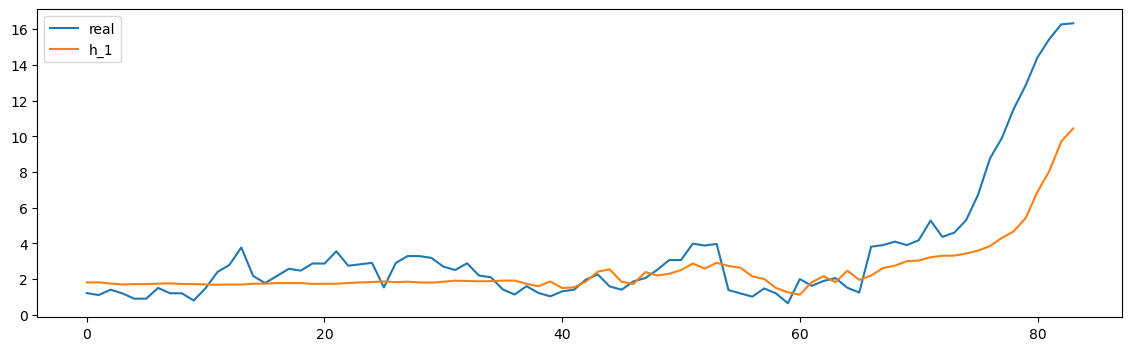

In [29]:
plt.figure(figsize=(14, 4))
plt.plot(yoy_real_test.reset_index(drop=True), label = "real")

plt.plot(y_pred, label = "h_1")
plt.legend()
plt.show()

## h = 2

In [11]:
h = 2
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

best_param = mine_s.hyperparam_tuning_optuna(mine_s.objective_xgb, X_cat_train, y_cat_train)

# save best_param:

with open(f'models/{model}_h_{h}_hyperparam.json', 'w') as json_file:
    json.dump(best_param, json_file)

N, T = len(X_cat_train), len(X_cat_test)

y_pred = generate_forecast(X = cat_df, y = HICP_cat, N = N, T = T, h = h, hyperparam=best_param)
food_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = y_pred


Horizon: 2
Training predictor period: 1997-01-31 00:00:00 to 2015-10-31 00:00:00
Training dependent variable period: 1997-03-31 00:00:00 to 2015-12-31 00:00:00
Number of finished trials: 1000
Horizon: 2
------------------------
Training period - features: 1997-01-31 00:00:00 to 2015-10-31 00:00:00
Training period - target : 1997-03-31 00:00:00 to 2015-12-31 00:00:00
Test period - features: DatetimeIndex(['2015-11-30'], dtype='datetime64[ns]', name='date', freq=None)
Test period - target : DatetimeIndex(['2016-01-31'], dtype='datetime64[ns]', name='date', freq=None)
Forecast: [1.6842]
-------------------------------------------------------
Training period - features: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training period - target : 1997-03-31 00:00:00 to 2016-01-31 00:00:00
Test period - features: DatetimeIndex(['2015-12-31'], dtype='datetime64[ns]', name='date', freq=None)
Test period - target : DatetimeIndex(['2016-02-29'], dtype='datetime64[ns]', name='date', freq=None)
Forecast:

## h = 3

In [12]:
h = 3
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

best_param = mine_s.hyperparam_tuning_optuna(mine_s.objective_xgb, X_cat_train, y_cat_train)

# save best_param:

with open(f'models/{model}_h_{h}_hyperparam.json', 'w') as json_file:
    json.dump(best_param, json_file)

N, T = len(X_cat_train), len(X_cat_test)

y_pred = generate_forecast(X = cat_df, y = HICP_cat, N = N, T = T, h = h, hyperparam=best_param)
food_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = y_pred


Horizon: 3
Training predictor period: 1997-01-31 00:00:00 to 2015-09-30 00:00:00
Training dependent variable period: 1997-04-30 00:00:00 to 2015-12-31 00:00:00
Number of finished trials: 1000
Horizon: 3
------------------------
Training period - features: 1997-01-31 00:00:00 to 2015-09-30 00:00:00
Training period - target : 1997-04-30 00:00:00 to 2015-12-31 00:00:00
Test period - features: DatetimeIndex(['2015-10-31'], dtype='datetime64[ns]', name='date', freq=None)
Test period - target : DatetimeIndex(['2016-01-31'], dtype='datetime64[ns]', name='date', freq=None)
Forecast: [1.3273658]
-------------------------------------------------------
Training period - features: 1997-01-31 00:00:00 to 2015-10-31 00:00:00
Training period - target : 1997-04-30 00:00:00 to 2016-01-31 00:00:00
Test period - features: DatetimeIndex(['2015-11-30'], dtype='datetime64[ns]', name='date', freq=None)
Test period - target : DatetimeIndex(['2016-02-29'], dtype='datetime64[ns]', name='date', freq=None)
Foreca

In [13]:
food_cat_prediction

,xgb_food_h_1,xgb_food_h_2,xgb_food_h_3
2016-01-31,1.456735,1.684200,1.327366
2016-02-29,1.561387,0.897192,0.887290
2016-03-31,1.489828,1.047011,0.772796
2016-04-30,1.040370,1.194955,1.232249
2016-05-31,1.005898,1.296793,1.464055
...,...,...,...
2022-08-31,6.435944,3.928889,4.929259
2022-09-30,7.501304,6.534640,4.795111
2022-10-31,9.717562,6.745116,7.938904
2022-11-30,11.234087,9.469630,8.797004


In [14]:
mine_g.save_forecast(forecast_result_df=food_cat_prediction.reset_index(drop=True), cat_file_path=save_cat_file_path, category=cat_short)

------------------

# Energy:

In [18]:
category = 'Energy'
cat_short = 'energy'
hicp_cat_path = f'data/preprocessed/{cat_short}_yoy_infl.csv'
save_cat_file_path = f'data/forecast_results/{cat_short}_forecast.csv'

HICP_monthly, HICP_class, HICP_cat = mine_g.import_data_all(hicp_all_path=hicp_all_path,
                                                     hicp_class_path=hicp_class_path,
                                                     hicp_cat_path=hicp_cat_path)

cat_df = mine_g.split_into_category(category=category,
                             HICP_class=HICP_class,
                             HICP_monthly=HICP_monthly)
energy_cat_prediction = pd.DataFrame(index=date_range)

Number of items in Energy group:  14


/Users/lananhnguyen/Desktop/thesis/thesis_code/main/packages/mine_generic.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df.fillna(0, inplace=True)


In [19]:
h = 1
cat_df = pd.merge(cat_df, HICP_cat, how='inner', left_index=True, right_index=True)
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

best_param = mine_s.hyperparam_tuning_optuna(mine_s.objective_xgb, X_cat_train, y_cat_train)
N, T = len(X_cat_train), len(X_cat_test)

y_pred = generate_forecast(X = cat_df, y = HICP_cat, N = N, T = T, h = h, hyperparam=best_param)
energy_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = y_pred


Horizon: 1
Training predictor period: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training dependent variable period: 1997-02-28 00:00:00 to 2015-12-31 00:00:00
Number of finished trials: 1000
Horizon: 1
------------------------
Training period - features: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training period - target : 1997-02-28 00:00:00 to 2015-12-31 00:00:00
Test period - features: DatetimeIndex(['2015-12-31'], dtype='datetime64[ns]', name='date', freq=None)
Test period - target : DatetimeIndex(['2016-01-31'], dtype='datetime64[ns]', name='date', freq=None)
Forecast: [-6.755557]
-------------------------------------------------------
Training period - features: 1997-01-31 00:00:00 to 2015-12-31 00:00:00
Training period - target : 1997-02-28 00:00:00 to 2016-01-31 00:00:00
Test period - features: DatetimeIndex(['2016-01-31'], dtype='datetime64[ns]', name='date', freq=None)
Test period - target : DatetimeIndex(['2016-02-29'], dtype='datetime64[ns]', name='date', freq=None)
Foreca

In [16]:
for h in [1, 2, 3]:
    X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

    best_param = mine_s.hyperparam_tuning_optuna(mine_s.objective_xgb, X_cat_train, y_cat_train)

    # save best_param:

    with open(f'models/{model}_h_{h}_hyperparam.json', 'w') as json_file:
        json.dump(best_param, json_file)

    N, T = len(X_cat_train), len(X_cat_test)

    y_pred = generate_forecast(X = cat_df, y = HICP_cat, N = N, T = T, h = h, hyperparam=best_param)
    energy_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = y_pred


Horizon: 1
Training predictor period: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training dependent variable period: 1997-02-28 00:00:00 to 2015-12-31 00:00:00
Number of finished trials: 1000
Horizon: 1
------------------------
Training period - features: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training period - target : 1997-02-28 00:00:00 to 2015-12-31 00:00:00
Test period - features: DatetimeIndex(['2015-12-31'], dtype='datetime64[ns]', name='date', freq=None)
Test period - target : DatetimeIndex(['2016-01-31'], dtype='datetime64[ns]', name='date', freq=None)
Forecast: [-6.0335536]
-------------------------------------------------------
Training period - features: 1997-01-31 00:00:00 to 2015-12-31 00:00:00
Training period - target : 1997-02-28 00:00:00 to 2016-01-31 00:00:00
Test period - features: DatetimeIndex(['2016-01-31'], dtype='datetime64[ns]', name='date', freq=None)
Test period - target : DatetimeIndex(['2016-02-29'], dtype='datetime64[ns]', name='date', freq=None)
Forec

In [17]:
mine_g.save_forecast(forecast_result_df=energy_cat_prediction.reset_index(drop=True), cat_file_path=save_cat_file_path, category=cat_short)

In [20]:

yoy_real = pd.read_csv(f"data/preprocessed/{cat_short}_yoy_infl.csv", parse_dates=True, index_col='date')
yoy_real_test = yoy_real[(yoy_real.index > mine_g.train_test_split_date) & (yoy_real.index <= mine_g.max_X_date)]
#df_compare = pd.concat([energy_cat_prediction, yoy_real_test], axis = 1)

print(mean_absolute_error(yoy_real_test,energy_cat_prediction.iloc[:, 0]))
print(np.sqrt(mean_squared_error(yoy_real_test,energy_cat_prediction.iloc[:, 0])))

3.0313186892731467
4.671909446316836


## NEIG:

In [19]:
cat_short = 'neig'
category = 'Non-energy industrial goods (NEIG)'
hicp_cat_path = f'data/preprocessed/{cat_short}_yoy_infl.csv'
save_cat_file_path = f'data/forecast_results/{cat_short}_forecast.csv'

HICP_monthly, HICP_class, HICP_cat = mine_g.import_data_all(hicp_all_path=hicp_all_path,
                                                     hicp_class_path=hicp_class_path,
                                                     hicp_cat_path=hicp_cat_path)

cat_df = mine_g.split_into_category(category=category,
                             HICP_class=HICP_class,
                             HICP_monthly=HICP_monthly)
neig_cat_prediction = pd.DataFrame(index=date_range)

Number of items in Non-energy industrial goods (NEIG) group:  302


/Users/lananhnguyen/Desktop/thesis/thesis_code/main/packages/mine_generic.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df.fillna(0, inplace=True)


In [20]:
for h in [1, 2, 3]:
    X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

    best_param = mine_s.hyperparam_tuning_optuna(mine_s.objective_xgb, X_cat_train, y_cat_train)

    # save best_param:

    with open(f'models/{model}_h_{h}_hyperparam.json', 'w') as json_file:
        json.dump(best_param, json_file)

    N, T = len(X_cat_train), len(X_cat_test)

    y_pred = generate_forecast(X = cat_df, y = HICP_cat, N = N, T = T, h = h, hyperparam=best_param)
    neig_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = y_pred


Horizon: 1
Training predictor period: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training dependent variable period: 1997-02-28 00:00:00 to 2015-12-31 00:00:00
Number of finished trials: 1000
Horizon: 1
------------------------
Training period - features: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training period - target : 1997-02-28 00:00:00 to 2015-12-31 00:00:00
Test period - features: DatetimeIndex(['2015-12-31'], dtype='datetime64[ns]', name='date', freq=None)
Test period - target : DatetimeIndex(['2016-01-31'], dtype='datetime64[ns]', name='date', freq=None)
Forecast: [0.8298437]
-------------------------------------------------------
Training period - features: 1997-01-31 00:00:00 to 2015-12-31 00:00:00
Training period - target : 1997-02-28 00:00:00 to 2016-01-31 00:00:00
Test period - features: DatetimeIndex(['2016-01-31'], dtype='datetime64[ns]', name='date', freq=None)
Test period - target : DatetimeIndex(['2016-02-29'], dtype='datetime64[ns]', name='date', freq=None)
Foreca

In [21]:
mine_g.save_forecast(forecast_result_df=neig_cat_prediction.reset_index(drop=True), cat_file_path=save_cat_file_path, category=cat_short)

In [22]:
yoy_real = pd.read_csv(f"data/preprocessed/{cat_short}_yoy_infl.csv", parse_dates=True, index_col='date')
yoy_real_test = yoy_real[(yoy_real.index > mine_g.train_test_split_date) & (yoy_real.index <= mine_g.max_X_date)]
#df_compare = pd.concat([energy_cat_prediction, yoy_real_test], axis = 1)

print(mean_absolute_error(yoy_real_test,neig_cat_prediction.iloc[:, 0]))
print(np.sqrt(mean_squared_error(yoy_real_test,neig_cat_prediction.iloc[:, 0])))

0.8589574803267735
1.2256968475071839


# Services:

In [23]:
cat_short = 'services'
category = 'Services'
hicp_cat_path = f'data/preprocessed/{cat_short}_yoy_infl.csv'
save_cat_file_path = f'data/forecast_results/{cat_short}_forecast.csv'

HICP_monthly, HICP_class, HICP_cat = mine_g.import_data_all(hicp_all_path=hicp_all_path,
                                                     hicp_class_path=hicp_class_path,
                                                     hicp_cat_path=hicp_cat_path)

cat_df = mine_g.split_into_category(category=category,
                             HICP_class=HICP_class,
                             HICP_monthly=HICP_monthly)
services_cat_prediction = pd.DataFrame(index=date_range)

Number of items in Services group:  148


/Users/lananhnguyen/Desktop/thesis/thesis_code/main/packages/mine_generic.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df.fillna(0, inplace=True)


In [24]:
for h in [1, 2, 3]:
    X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

    best_param = mine_s.hyperparam_tuning_optuna(mine_s.objective_xgb, X_cat_train, y_cat_train)

    # save best_param:

    with open(f'models/{model}_h_{h}_hyperparam.json', 'w') as json_file:
        json.dump(best_param, json_file)

    N, T = len(X_cat_train), len(X_cat_test)

    y_pred = generate_forecast(X = cat_df, y = HICP_cat, N = N, T = T, h = h, hyperparam=best_param)
    services_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = y_pred


Horizon: 1
Training predictor period: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training dependent variable period: 1997-02-28 00:00:00 to 2015-12-31 00:00:00
Number of finished trials: 1000
Horizon: 1
------------------------
Training period - features: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training period - target : 1997-02-28 00:00:00 to 2015-12-31 00:00:00
Test period - features: DatetimeIndex(['2015-12-31'], dtype='datetime64[ns]', name='date', freq=None)
Test period - target : DatetimeIndex(['2016-01-31'], dtype='datetime64[ns]', name='date', freq=None)
Forecast: [2.024265]
-------------------------------------------------------
Training period - features: 1997-01-31 00:00:00 to 2015-12-31 00:00:00
Training period - target : 1997-02-28 00:00:00 to 2016-01-31 00:00:00
Test period - features: DatetimeIndex(['2016-01-31'], dtype='datetime64[ns]', name='date', freq=None)
Test period - target : DatetimeIndex(['2016-02-29'], dtype='datetime64[ns]', name='date', freq=None)
Forecas

In [25]:
yoy_real = pd.read_csv(f"data/preprocessed/{cat_short}_yoy_infl.csv", parse_dates=True, index_col='date')
yoy_real_test = yoy_real[(yoy_real.index > mine_g.train_test_split_date) & (yoy_real.index <= mine_g.max_X_date)]
#df_compare = pd.concat([energy_cat_prediction, yoy_real_test], axis = 1)

print(mean_absolute_error(yoy_real_test,services_cat_prediction.iloc[:, 0]))
print(np.sqrt(mean_squared_error(yoy_real_test,services_cat_prediction.iloc[:, 0])))

0.538195305865574
0.6867911129159167


In [26]:
mine_g.save_forecast(forecast_result_df=services_cat_prediction.reset_index(drop=True), cat_file_path=save_cat_file_path, category=cat_short)